## Benchmarking Scipy Signal vs cuSignal Time to Create Windows in Greenflow

The windows examples were taken from the example [cusignal windows notebook](https://github.com/rapidsai/cusignal/blob/branch-21.08/notebooks/api_guide/windows_examples.ipynb).

### General Parameters

In [1]:
import cupy.testing as cptest

In [2]:
from greenflow.dataframe_flow import (TaskGraph, TaskSpecSchema)

In [3]:
# Num Points in Array - Reduce if getting out of memory errors
M = int(1e7)

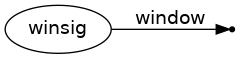

In [4]:
tgraph_win = TaskGraph.load_taskgraph('./taskgraphs/window_signal.gq.yaml')
tgraph_win.build()
tgraph_win.draw(show='ipynb', show_ports=True, pydot_options={'rankdir': 'LR'})

### General Cosine

In [5]:
HFT90D = [1, 1.942604, 1.340318, 0.440811, 0.043097]
win_params = {
    'window_type': 'general_cosine',
    'M': M,
    'a': HFT90D,
    'sym': False
}

replace_gpu = {
    'winsig': {
        TaskSpecSchema.conf: win_params
    }
}

replace_cpu = {
    'winsig': {
        TaskSpecSchema.conf: {
            **win_params,
            'use_cpu': True
        }
    }
}

(gwin,) = tgraph_win.run(['winsig.window'], replace=replace_gpu)
(cwin,) = tgraph_win.run(['winsig.window'], replace=replace_cpu)
cptest.assert_array_almost_equal(gwin, cwin)

In [6]:
gpu_time = %timeit -o (gwin,) = tgraph_win.run(['winsig.window'], replace=replace_gpu)

3.57 ms ± 25.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
cpu_time = %timeit -o (cwin,) = tgraph_win.run(['winsig.window'], replace=replace_cpu)

910 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
print('SPEEDUP: {}x'.format(round(cpu_time.average / gpu_time.average, 1)))

SPEEDUP: 255.2x


### Timing CuSignal Windows

Using the base taskgraph for generating a window we can use the programmatic API to profile and compare generating windows via cusignal on GPU and scipy on CPU.

In [9]:
from copy import deepcopy

default_params = {'M': M}  # M is defined above
wins_map = {
    'boxcar': {},
    'triang': {},
    'bohman': {},
    'blackman': {},
    'nuttall': {},
    'blackmanharris': {},
    'flattop': {},
    'bartlett': {},
    'hann': {},
    'tukey': {
        'params': {
            'alpha': 0.5,
            'sym': True
        }
    },
    'barthann': {},
    'general_hamming': {
        'params': {
            'alpha': 0.5,
            'sym': True
        }
    },
    'hamming': {},
    'kaiser': {
        'params': {
            'beta': 0.5
        }
    },
    'gaussian': {
        'params': {
            'std': 7
        }
    },
    'general_gaussian': {
        'params': {
            'p': 1.5,
            'sig': 7,  # for older API
        }
    },
    'cosine': {},
    'exponential': {
        'params': {
            'tau': 3.0
        }
    }
}

for wintype, winconf in wins_map.items():
    win_params = default_params.copy()
    win_params['window_type'] = wintype
    win_params.update(winconf.get('params', {}))
    replace_gpu = {
        'winsig': {
            TaskSpecSchema.conf: win_params,
        }
    }
    replace_cpu = deepcopy(replace_gpu)
    replace_cpu['winsig'][TaskSpecSchema.conf]['use_cpu'] = True
    print('WINDOW TYPE: {}'.format(wintype))
    print('GPU TIMING')
    tgraph_win.build(replace=replace_gpu)
    gpu_time = %timeit -o (gwin,) = tgraph_win.run(['winsig.window'], build=False)
    print('CPU TIMING')
    tgraph_win.build(replace=replace_cpu)
    cpu_time = %timeit -o (cwin,) = tgraph_win.run(['winsig.window'], build=False)
    print('SPEEDUP: {}x'.format(round(cpu_time.average / gpu_time.average, 1)))
    print('\n')

# reset tgraph build
tgraph_win.build()

WINDOW TYPE: boxcar
GPU TIMING
2.07 ms ± 52.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CPU TIMING
21.4 ms ± 61 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
SPEEDUP: 10.3x


WINDOW TYPE: triang
GPU TIMING
2.05 ms ± 8.82 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CPU TIMING
70.4 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
SPEEDUP: 34.4x


WINDOW TYPE: bohman
GPU TIMING
2.05 ms ± 8.12 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CPU TIMING
446 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SPEEDUP: 218.0x


WINDOW TYPE: blackman
GPU TIMING
2.98 ms ± 8.52 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CPU TIMING
525 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SPEEDUP: 175.9x


WINDOW TYPE: nuttall
GPU TIMING
3.03 ms ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CPU TIMING
719 ms ± 920 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
SPEEDUP: 237.3x